<a href="https://colab.research.google.com/github/edwardLum/learning-google-ads/blob/main/clustering_search_terms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

**Imports**

Libraries used:

* **pandas**: Pandas pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language. User guide [here](https://pandas.pydata.org/docs/user_guide/index.**html**)

* **gensim**: Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Documentation [here](https://github.com/RaRe-Technologies/gensim/#documentation)

* **sklean**: scikit-learn is a free software machine learning library for the Python programming language.[3] It features various classification, regression and clustering algorithms and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy. User guide [here](https://scikit-learn.org/stable/user_guide.html)



In [9]:
import pandas as pd
import chardet

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

from google.colab import files

**Files upload**

Choose file to upload and pass them to a list

In [10]:
uploaded = files.upload()

filenames = []

# Upload files:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  filenames.append(fn)

Saving Search terms report - 2023-10-17T184921.753.csv to Search terms report - 2023-10-17T184921.753 (1).csv
User uploaded file "Search terms report - 2023-10-17T184921.753 (1).csv" with length 222554 bytes


**Detect encoding**

Use the detect method of chardet to detect the encoding of the provided file.

In [11]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

file_path = f"/content/{filenames[0]}"
original_encoding = detect_encoding(file_path)

print(f"Detected encoding: {original_encoding}")

Detected encoding: UTF-16


# Data Manipulation

**Read data**

Create dataframe using the provided csv. Provide:

* the separator the csv uses
* the encoding of the file
* how many rows have to be skipped (if any)
* thousands separator

Remove summary rows if any.

In [12]:
# Load data
all_terms = pd.read_csv(file_path, sep='\t',
                        encoding=original_encoding,
                        skiprows=2,
                        thousands=',')

**Process data**

Actions:
* Remove summary rows
* Remove unnecessary colums
* Deduplicate and aggregate metrics


In [13]:
# Remove Summary rows
all_terms = all_terms[~all_terms['Search term'].str.startswith('Total: ')]

# Remove unnecessary columns
columns_to_drop = ['Conv. rate', 'CTR', 'Cost / conv.', 'Avg. CPC']
all_terms_required_columns = all_terms.drop(columns=columns_to_drop)

aggregated_terms = all_terms_required_columns.groupby('Search term').agg({
    'Clicks': 'sum',
    'Cost': 'sum',
    'Impr.': 'sum',
    'Conversions': 'sum',
}).reset_index()

data = aggregated_terms

# Vectorization

**TF-IDF vectorization**

TF-IDF (Term Frequency-Inverse Document Frequency) vectorization is a technique used to quantify the importance of words in a document relative to a corpus. It weighs terms based on their frequency in a document, penalized by their frequency across all documents. This results in emphasizing terms that are unique or specific to a particular document, while downplaying common or repetitive terms.

Need to provide two parameters:

**max_df**: This parameter is used to remove terms that appear too frequently in the corpus. It can be either:
an integer (e.g., 5), which specifies the maximum number of documents a term can appear in for it to be included as a feature, or
a float (e.g., 0.85), which represents a proportion of the entire corpus.

If a term appears in more than this proportion of documents, it will be discarded.
The main idea behind max_df is that words appearing in a very large proportion of documents are likely to be common words (e.g., stopwords) that might not carry specific, meaningful information about the content of a document.

**max_features**: This parameter limits the number of top features (words or tokens) the vectorizer will learn from the corpus based on term frequency.
If set (e.g., to 10000), the vectorizer will only consider the top max_features ordered by term frequency across the corpus.

This can be useful to limit the dimensionality of the output, especially when dealing with very large datasets where memory or computational resources are a concern.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=10000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Search term'])

**Inspect TF-IDF output**

**Print feature names**: which words or tokens the vectorizer has recognized in given corpus

In [22]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names)

['10' '100' '10bet' '1bet' '1x' '1xbet' '22bet' '365' '4rabet' '50'
 '888sport' 'account' 'activate' 'adsrv' 'africa' 'african' 'airtime'
 'alp' 'apk' 'app' 'apps' 'aviator' 'batway' 'best' 'bestsportsbetting'
 'bet' 'bet365' 'betbright' 'betfair' 'betfred' 'betking' 'betnow'
 'betolimp' 'betonline' 'betpawa' 'bets' 'bettabets' 'better' 'betting'
 'betup' 'betway' 'betxchange' 'bonus' 'buy' 'cash' 'casino' 'change'
 'com' 'companies' 'contact' 'correct' 'cup' 'day' 'deposit' 'details'
 'does' 'download' 'eacdn' 'easy' 'ebet' 'esports' 'exchange' 'firstbet'
 'football' 'fredbet' 'free' 'gambling' 'game' 'games' 'gbet' 'gbets'
 'gives' 'hack' 'hollywood' 'hollywoodbet' 'hollywoodbets' 'interbet'
 'international' 'jabula' 'jackpot' 'land' 'live' 'log' 'login' 'lotto'
 'lottoland' 'lottostar' 'mbet' 'mega' 'mines' 'mobile' 'money' 'net'
 'new' 'news' 'number' 'odds' 'online' 'ontario' 'ott' 'palace'
 'palacebet' 'palmerbet' 'paripesa' 'pesa' 'picks' 'pin' 'place' 'play'
 'playa' 'playbet' 

**Check IDF values**

This provides an idea of how unique or rare each word is across the entire corpus.

Higher IDF values mean the word is rarer across your documents.

In [23]:
idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
idf_df = pd.DataFrame(list(idf_values.items()), columns=["token", "idf"]).sort_values(by="idf", ascending=False)

print(idf_df)

          token       idf
0            10  6.365976
134  soccerbets  6.365976
108        play  6.365976
109       playa  6.365976
111       poker  6.365976
..          ...       ...
119    register  3.274934
40       betway  3.208976
25          bet  2.782457
83        login  2.755058
38      betting  2.424394

[200 rows x 2 columns]


**Review Max and Min TF-IDF Scores**

Understand the range of values and potentially identify terms that are too common or too rare.

In [25]:
max_tf_idf = tfidf_matrix.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_tf_idf.argsort()

print("Tokens with highest tfidf:", [feature_names[i] for i in sorted_by_tfidf[-10:]])
print("Tokens with lowest tfidf:", [feature_names[i] for i in sorted_by_tfidf[:10]])

Tokens with highest tfidf: ['sunbet', 'sunbets', 'betway', 'superbet', 'bet365', 'bet', 'betonline', 'gbet', 'sportybet', 'sportsbetting']
Tokens with lowest tfidf: ['spin', 'real', 'using', 'buy', '50', 'adsrv', 'wlhollywoodbets', 'eacdn', 'win', 'south']


# Clustering

In [41]:
# Number of clusters - You might want to adjust this based on domain knowledge
n_clusters = 70

# Clustering for TF-IDF
kmeans_tfidf = KMeans(n_clusters=n_clusters)
data['tfidf_cluster'] = kmeans_tfidf.fit_predict(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [42]:
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(data[data['tfidf_cluster'] == i]['Search term'])
    print("\n")

Cluster 0:
30    bet alp
Name: Search term, dtype: object


Cluster 1:
64                                 betting app
65         betting app with free sign up bonus
143    free sign up bonus betting south africa
Name: Search term, dtype: object


Cluster 2:
41                   bet sa
42          bet sa register
203    new sa betting sites
233        sa betting sites
235         sa betway login
236           sa sports bet
287            sportpesa sa
Name: Search term, dtype: object


Cluster 3:
88                            betting sports
104               betway live sports betting
125        download world sports betting app
291                        sports bets login
292                       sports betting app
293                sports betting game betup
294                     sports betting login
298                              sports pesa
366                              ubet sports
383                     world sports betting
384    world sports betting activate account
385  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 40, the average silhouette_score is : 0.1460063469185798


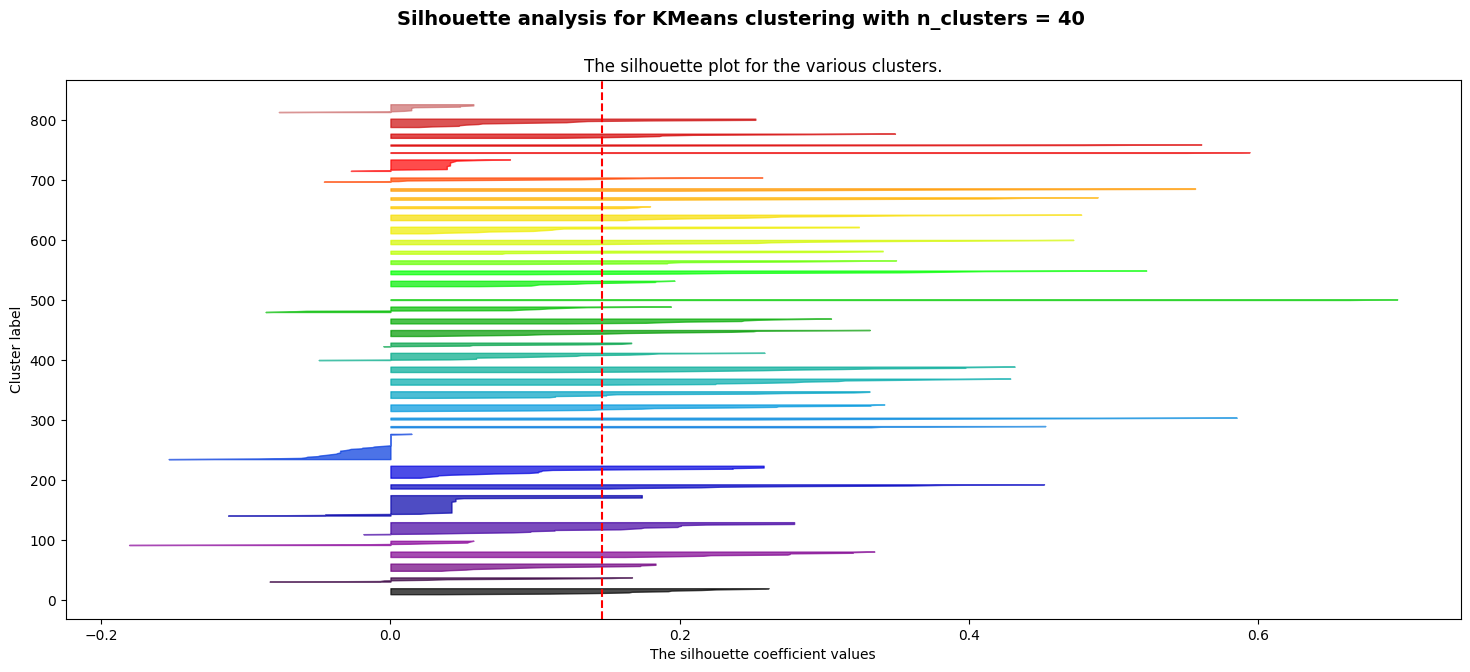

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 50, the average silhouette_score is : 0.15829493761792013


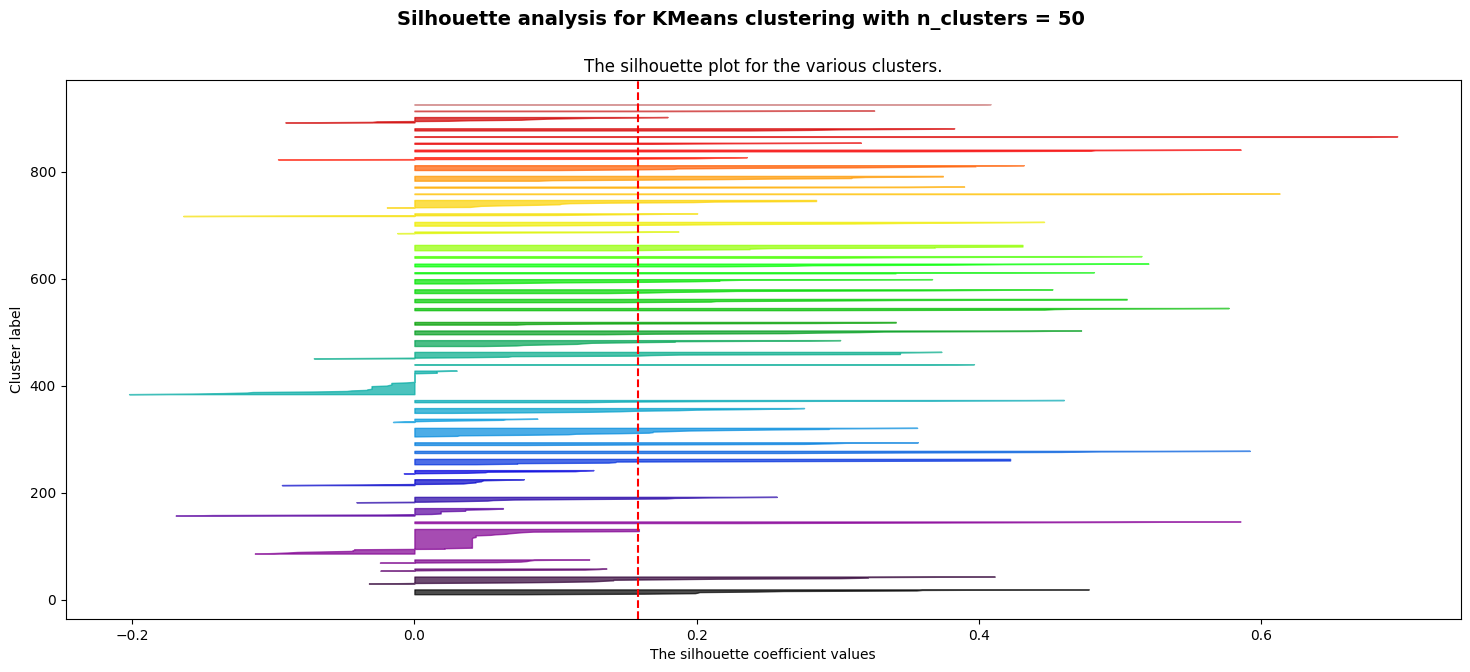

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 60, the average silhouette_score is : 0.17817094518249732


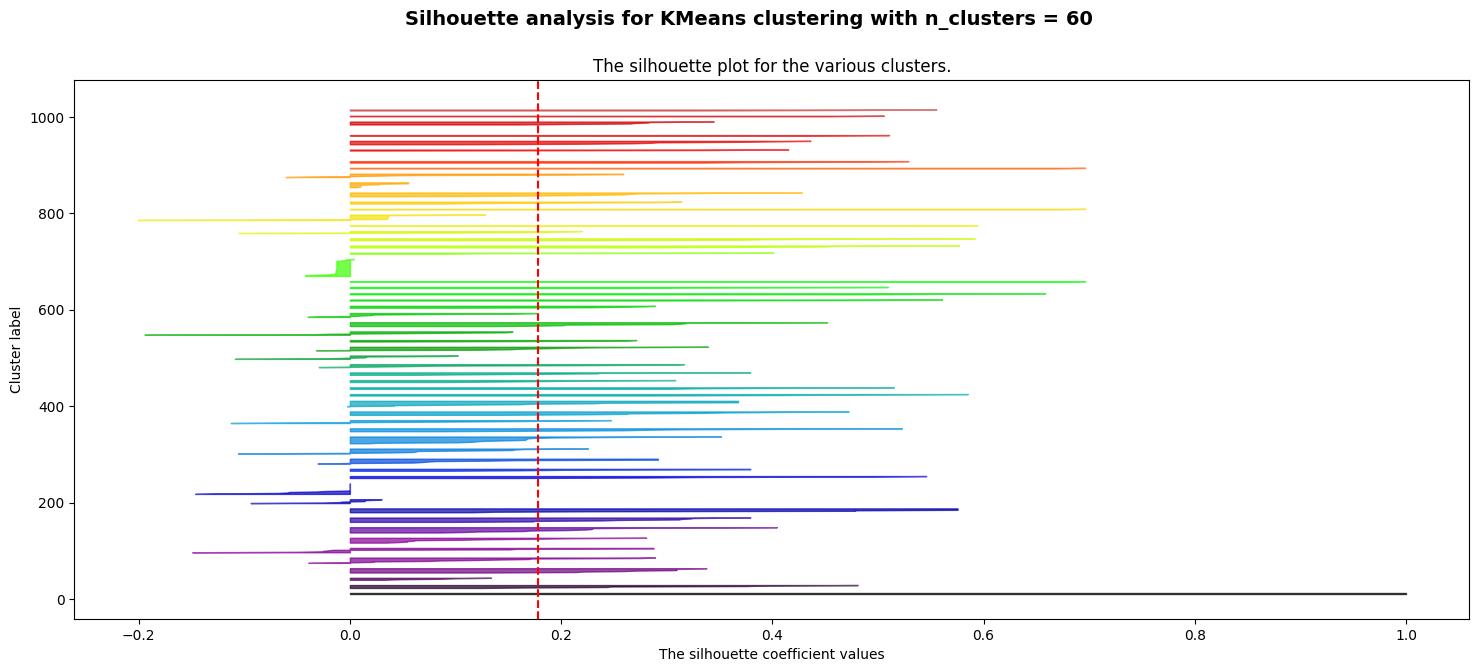

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 70, the average silhouette_score is : 0.17809179436298825


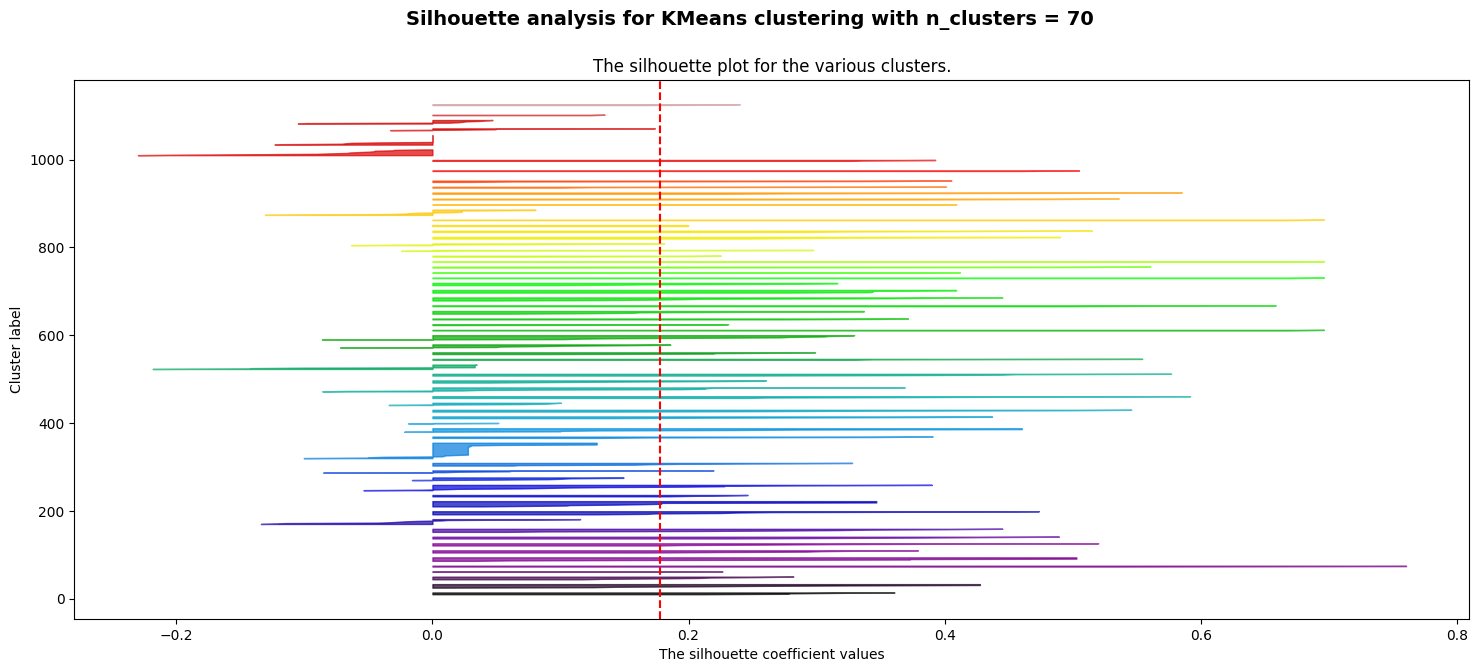

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

# Assuming tfidf_matrix from your previous code is your data
range_n_clusters = [40, 50, 60, 70]  # you can extend this as needed
X = tfidf_matrix.toarray()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.suptitle(f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')
    plt.show()
